In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# install plotly
!pip install plotly
!pip install nbformat

# set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


# Video Game Clustering Project
## Unsupervised Learning Framework for Game Archetype Segmentation

### Project Goal
Automatically segment video games into distinct archetypes (e.g., "Critically Acclaimed Blockbusters", "Underrated Gems") by analyzing patterns between commercial performance and critical reception.

### Dataset
Kaggle Video Game Sales with Ratings: https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings/data

## data loading and display of values
done

In [2]:
try:
    github_url = 'https://raw.githubusercontent.com/Cegeurun/CCADMACL_PROJECT/main/data/Video_Games_Sales_as_at_22_Dec_2016.csv'
    
    df = pd.read_csv(github_url)

    print(f"Shape: {df.shape}")
    print(f"\nFirst few rows:")
    display(df.head())
    
    print(f"\nDataset Info:")
    print(df.info())
    
    print(f"\nBasic Statistics:")
    display(df.describe())
    
    print(f"\nMissing Values:")
    print(df.isnull().sum())
    
    print(f"Number of duplicate rows (name only): {df['Name'].duplicated().sum()}")
    


except Exception as e:
    print(f"error loading dataset: {str(e)}")

Shape: (16719, 16)

First few rows:


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000



Missing Values:
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64
Number of duplicate rows (name only): 5156


## data cleaning
done

In [3]:
# df_relevant = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']].astype(float).to_numpy()
# df_X = df[['NA_Sales', 'EU_Sales']].astype(float).to_numpy()
df_relevant = df[['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']]
#a
# convert non-numeric values in User_Score to NaN
df_relevant['User_Score'] = pd.to_numeric(df_relevant['User_Score'], errors='coerce')

# remove games with very low review counts cause scores from tiny samples are unreliable
df_relevant = df_relevant[(df_relevant['Critic_Count'] >= 5) & (df_relevant['User_Count'] >= 5)]

# drop rows missing any of the key columns
df_relevant = df_relevant.dropna(subset=['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'])
print(df_relevant.isnull().sum())

df_relevant.drop_duplicates(subset=['Name'], inplace=True)

print(f"\nMissing Values:")
print(df_relevant.isnull().sum())
    
print(f"\nNumber of duplicate rows (name only):")
print(df_relevant['Name'].duplicated().sum())

Name            0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
Critic_Score    0
Critic_Count    0
User_Score      0
User_Count      0
dtype: int64

Missing Values:
Name            0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
Critic_Score    0
Critic_Count    0
User_Score      0
User_Count      0
dtype: int64

Number of duplicate rows (name only):
0


## feature engineering

In [4]:
# create user-critic discrepancy feature
# Critic_Score is 0-100, User_Score is 0-10, so scale User_Score to match
df_relevant['User_Score_Scaled'] = df_relevant['User_Score'] * 10

# calculate discrepancy (positive means users rate higher than critics)
df_relevant['User_Critic_Discrepancy'] = df_relevant['User_Score_Scaled'] - df_relevant['Critic_Score']

print('User-Critic Discrepancy Statistics:')
print(df_relevant['User_Critic_Discrepancy'].describe())

User-Critic Discrepancy Statistics:
count    4253.000000
mean        3.114743
std        12.043743
min       -59.000000
25%        -4.000000
50%         3.000000
75%        10.000000
max        62.000000
Name: User_Critic_Discrepancy, dtype: float64


# EXploratory data analysis (EDA)
done

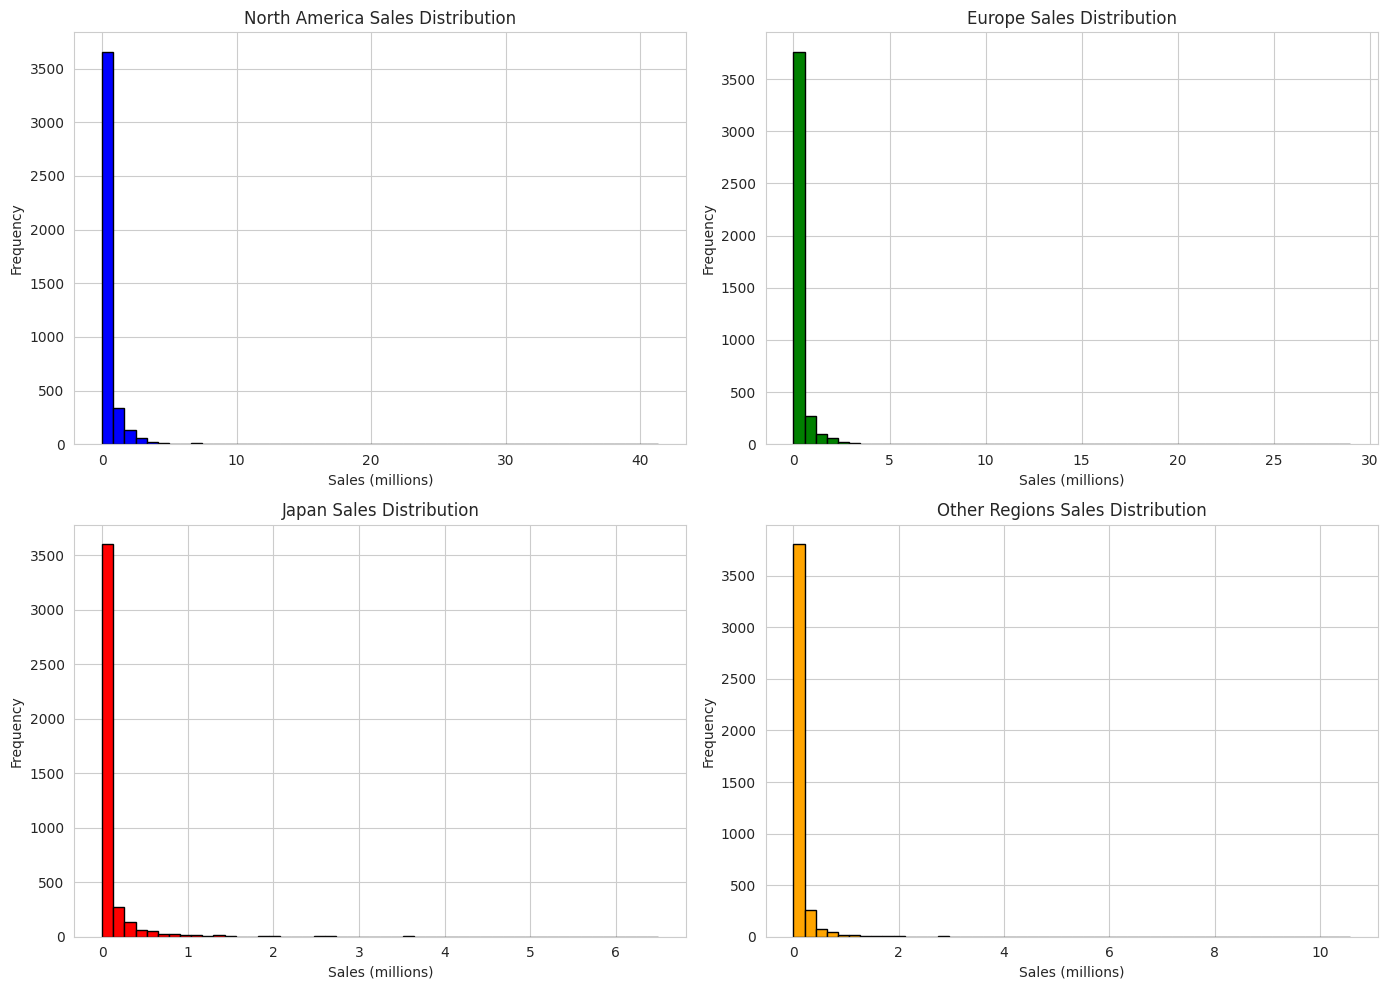

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df_relevant['NA_Sales'], bins=50, edgecolor='black', color='blue')
axes[0, 0].set_title('North America Sales Distribution')
axes[0, 0].set_xlabel('Sales (millions)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df_relevant['EU_Sales'], bins=50, edgecolor='black', color='green')
axes[0, 1].set_title('Europe Sales Distribution')
axes[0, 1].set_xlabel('Sales (millions)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(df_relevant['JP_Sales'], bins=50, edgecolor='black', color='red')
axes[1, 0].set_title('Japan Sales Distribution')
axes[1, 0].set_xlabel('Sales (millions)')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(df_relevant['Other_Sales'], bins=50, edgecolor='black', color='orange')
axes[1, 1].set_title('Other Regions Sales Distribution')
axes[1, 1].set_xlabel('Sales (millions)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

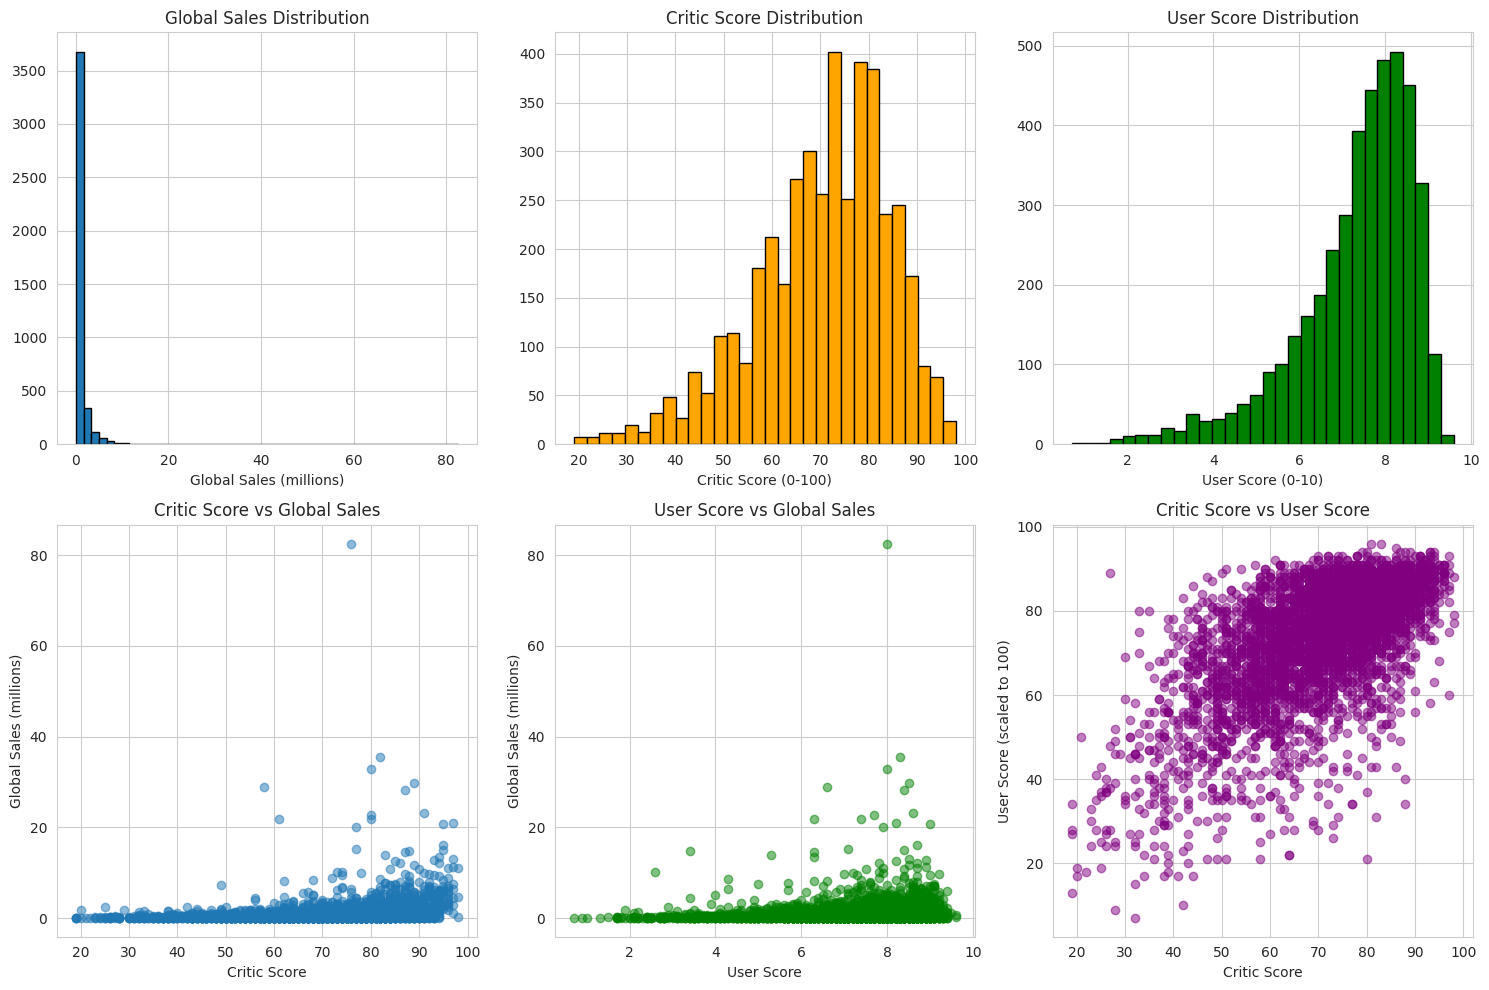

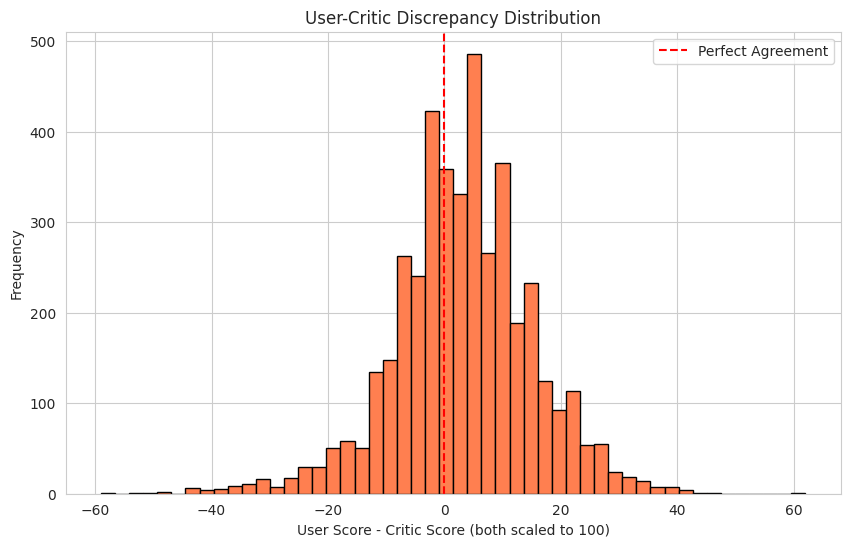

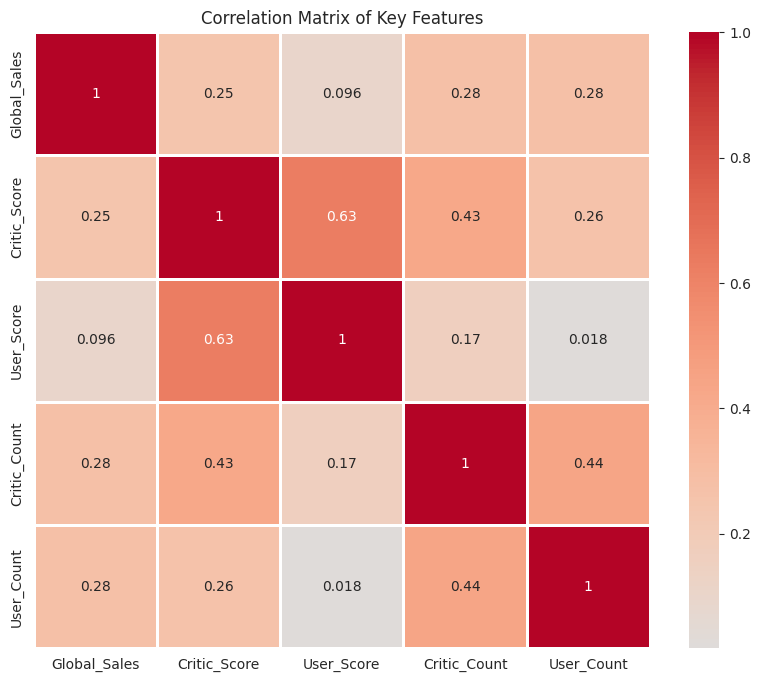

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# to understand data before clustering
axes[0, 0].hist(df_relevant['Global_Sales'], bins=50, edgecolor='black')
axes[0, 0].set_title('Global Sales Distribution')
axes[0, 0].set_xlabel('Global Sales (millions)')

axes[0, 1].hist(df_relevant['Critic_Score'], bins=30, edgecolor='black', color='orange')
axes[0, 1].set_title('Critic Score Distribution')
axes[0, 1].set_xlabel('Critic Score (0-100)')

axes[0, 2].hist(df_relevant['User_Score'], bins=30, edgecolor='black', color='green')
axes[0, 2].set_title('User Score Distribution')
axes[0, 2].set_xlabel('User Score (0-10)')

axes[1, 0].scatter(df_relevant['Critic_Score'], df_relevant['Global_Sales'], alpha=0.5)
axes[1, 0].set_title('Critic Score vs Global Sales')
axes[1, 0].set_xlabel('Critic Score')
axes[1, 0].set_ylabel('Global Sales (millions)')

axes[1, 1].scatter(df_relevant['User_Score'], df_relevant['Global_Sales'], alpha=0.5, color='green')
axes[1, 1].set_title('User Score vs Global Sales')
axes[1, 1].set_xlabel('User Score')
axes[1, 1].set_ylabel('Global Sales (millions)')

axes[1, 2].scatter(df_relevant['Critic_Score'], df_relevant['User_Score']*10, alpha=0.5, color='purple')
axes[1, 2].set_title('Critic Score vs User Score')
axes[1, 2].set_xlabel('Critic Score')
axes[1, 2].set_ylabel('User Score (scaled to 100)')

plt.tight_layout()
plt.show()

# plot user-critic discrepancy distribution
plt.figure(figsize=(10, 6))
plt.hist(df_relevant['User_Critic_Discrepancy'], bins=50, edgecolor='black', color='coral')
plt.title('User-Critic Discrepancy Distribution')
plt.xlabel('User Score - Critic Score (both scaled to 100)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='Perfect Agreement')
plt.legend()
plt.show()

# tinitignan ung correlation between sa variables, answers stuff like "commercial success ~= high critic scores"
correlation_matrix = df_relevant[['Global_Sales', 'Critic_Score', 'User_Score', 'Critic_Count', 'User_Count']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Key Features')
plt.show()

# df_relevant['Critic_User_Diff'] = df_relevant['Critic_Score'] - (df_relevant['User_Score'] * 10)
# print("\nCritic-User Score Difference Statistics:")
# print(df_relevant['Critic_User_Diff'].describe())

# plt.figure(figsize=(10, 6))
# plt.hist(df_relevant['Critic_User_Diff'], bins=50, edgecolor='black', color='coral')
# plt.title('Critic-User Score Difference Distribution')
# plt.xlabel('Critic Score - User Score (both scaled to 100)')
# plt.ylabel('Frequency')
# plt.axvline(x=0, color='red', linestyle='--', label='Perfect Agreement')
# plt.legend()
# plt.show()

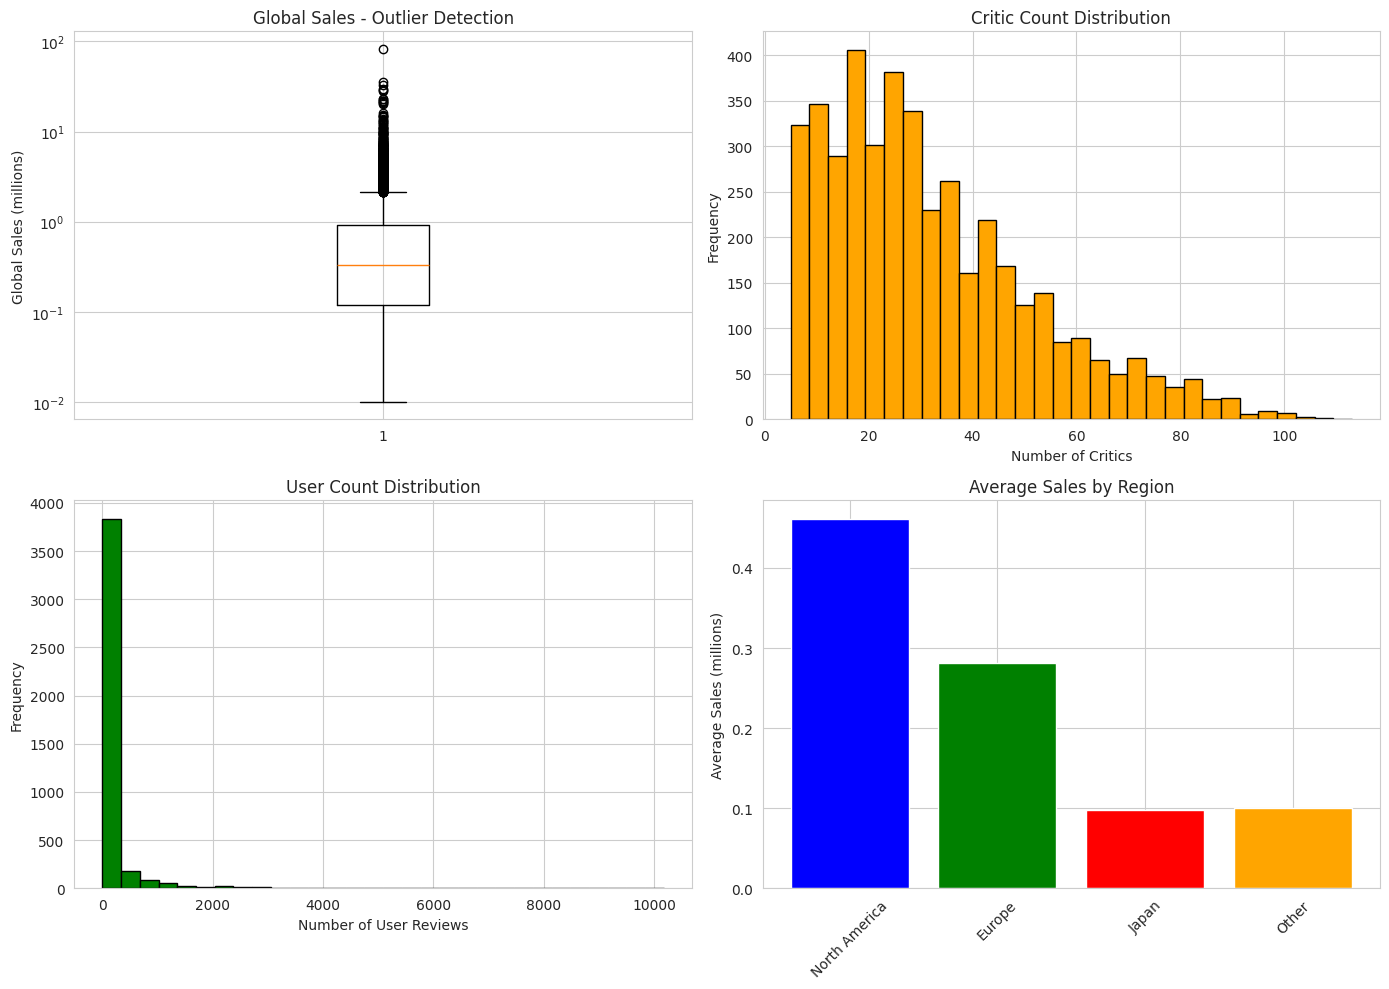


Sales Statistics:
Max Global Sales: 82.53 million
75th percentile: 0.92 million
Median: 0.33 million


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot to identify sales outliers
axes[0, 0].boxplot(df_relevant['Global_Sales'])
axes[0, 0].set_title('Global Sales - Outlier Detection')
axes[0, 0].set_ylabel('Global Sales (millions)')
axes[0, 0].set_yscale('log') # gumamit po ako ng log scale kase sobrang napipi ung box dahil sa outlier hahahahahaha

# Review count distributions
axes[0, 1].hist(df_relevant['Critic_Count'], bins=30, edgecolor='black', color='orange')
axes[0, 1].set_title('Critic Count Distribution')
axes[0, 1].set_xlabel('Number of Critics')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(df_relevant['User_Count'], bins=30, edgecolor='black', color='green')
axes[1, 0].set_title('User Count Distribution')
axes[1, 0].set_xlabel('Number of User Reviews')
axes[1, 0].set_ylabel('Frequency')

# Regional sales comparison
regional_means = [
    df_relevant['NA_Sales'].mean(),
    df_relevant['EU_Sales'].mean(),
    df_relevant['JP_Sales'].mean(),
    df_relevant['Other_Sales'].mean()
]
regions = ['North America', 'Europe', 'Japan', 'Other']

axes[1, 1].bar(regions, regional_means, color=['blue', 'green', 'red', 'orange'])
axes[1, 1].set_title('Average Sales by Region')
axes[1, 1].set_ylabel('Average Sales (millions)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nSales Statistics:")
print(f"Max Global Sales: {df_relevant['Global_Sales'].max():.2f} million")
print(f"75th percentile: {df_relevant['Global_Sales'].quantile(0.75):.2f} million")
print(f"Median: {df_relevant['Global_Sales'].median():.2f} million")

# data preprocessing
done, idocument nalang na mababa ung variance kapag ininclude ung regional sales metric

In [8]:
# # Convert to array
df_X = df_relevant[['Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score_Scaled', 'User_Count', 'User_Critic_Discrepancy']].astype(float).to_numpy()

# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_X)

# X_scaled.shape

# Apply log transformation to handle outliers
X_scaled = df_X.copy()
# shift User_Critic_Discrepancy to be positive
min_discrepancy = df_X[:, 5].min()
if min_discrepancy < 0:
    X_scaled[:, 5] = X_scaled[:, 5] - min_discrepancy
# apply log transformation
X_scaled = np.log1p(X_scaled)


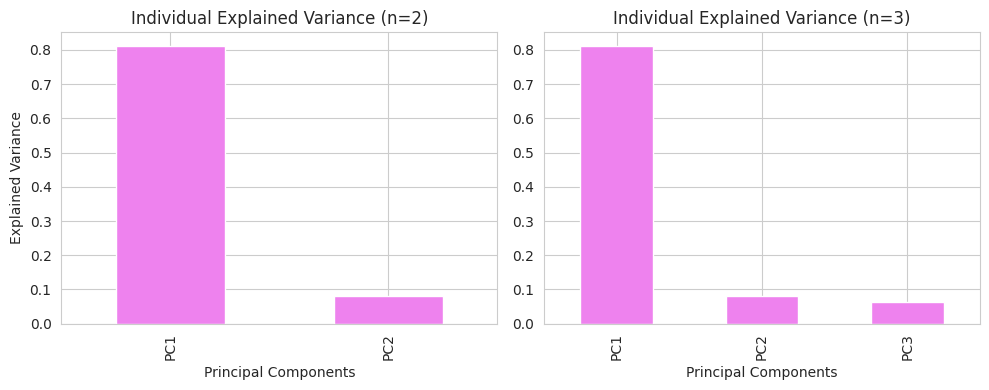

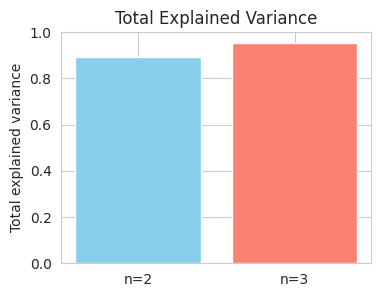

In [9]:
# Apply PCA with n=2 and n=3
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_scaled) # n_components=3 provided better results so eto gagamitin natin.
explained_variance = pca.explained_variance_ratio_

pca2 = PCA(n_components=2)
pca2.fit(X_scaled)
explained_variance_2 = pca2.explained_variance_ratio_

# Individual explained variance side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pd.DataFrame(explained_variance_2).plot.bar(color='violet', legend=False, ax=axes[0])
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance')
axes[0].set_title('Individual Explained Variance (n=2)')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['PC1', 'PC2'])

pd.DataFrame(explained_variance).plot.bar(color='violet', legend=False, ax=axes[1])
axes[1].set_xlabel('Principal Components')
axes[1].set_title('Individual Explained Variance (n=3)')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['PC1', 'PC2', 'PC3'])

plt.tight_layout()
plt.show()

# Total explained variance comparison
total_variance_2 = explained_variance_2.sum()
total_variance_3 = explained_variance.sum()

plt.figure(figsize=(4, 3))
plt.bar(['n=2', 'n=3'], [total_variance_2, total_variance_3], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Total explained variance')
plt.title('Total Explained Variance')
plt.show()

# Put heatmap here


PCA Loadings (n=2):


,PC1,PC2
Global_Sales,0.290735,0.004045
Critic_Score,0.104520,0.049676
Critic_Count,0.461338,0.455419
User_Score_Scaled,0.038308,0.048838
User_Count,1.430473,-0.152081
User_Critic_Discrepancy,-0.082027,0.009682


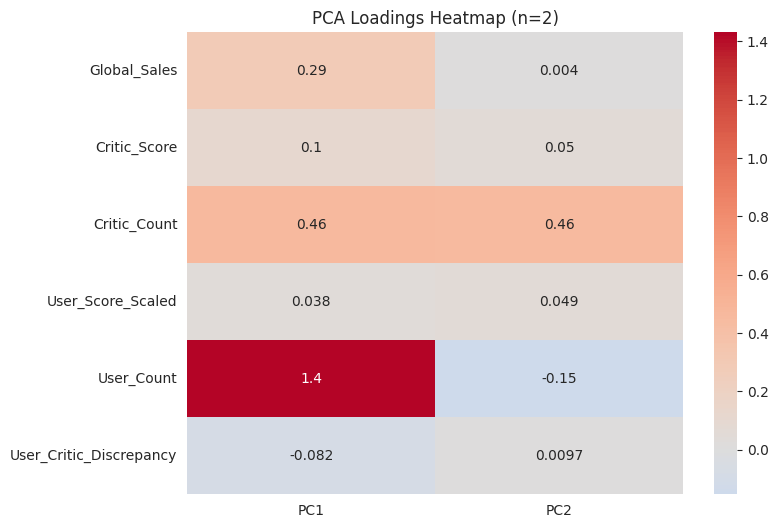

PCA Loadings (n=3):


,PC1,PC2,PC3
Global_Sales,0.290735,0.004045,0.412753
Critic_Score,0.104520,0.049676,0.043840
Critic_Count,0.461338,0.455419,-0.037584
User_Score_Scaled,0.038308,0.048838,0.035528
User_Count,1.430473,-0.152081,-0.076644
User_Critic_Discrepancy,-0.082027,0.009682,-0.012572


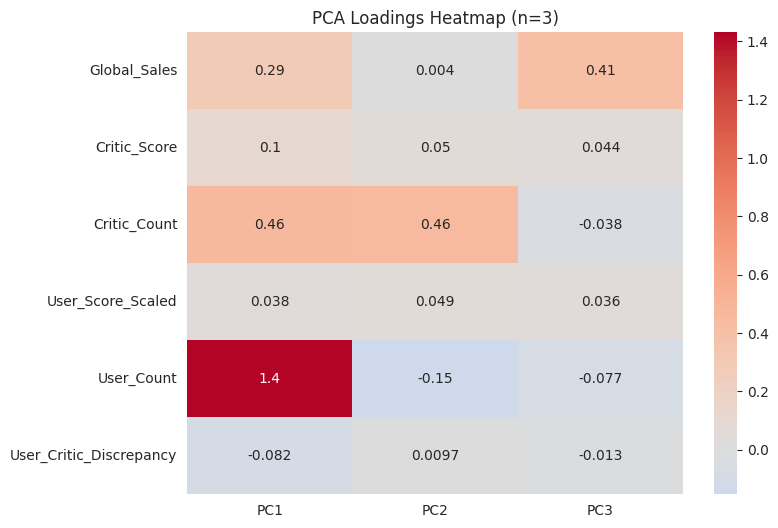

In [10]:
# PCA loadings for n=2
loadings_2 = pca2.components_.T * np.sqrt(pca2.explained_variance_)
feature_names = ['Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score_Scaled', 'User_Count', 'User_Critic_Discrepancy']
loading_matrix_2 = pd.DataFrame(loadings_2, columns=['PC1', 'PC2'], index=feature_names)

print('PCA Loadings (n=2):')
display(loading_matrix_2)

plt.figure(figsize=(8, 6))
sns.heatmap(loading_matrix_2, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings Heatmap (n=2)')
plt.show()

# PCA loadings for n=3
loadings_3 = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix_3 = pd.DataFrame(loadings_3, columns=['PC1', 'PC2', 'PC3'], index=feature_names)

print('PCA Loadings (n=3):')
display(loading_matrix_3)

plt.figure(figsize=(8, 6))
sns.heatmap(loading_matrix_3, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings Heatmap (n=3)')
plt.show()

## Plotting the data

In [11]:
import plotly.express as px
import plotly.io as pio

# Set the default renderer to 'vscode'
pio.renderers.default = "vscode"

# Now create and show the figure (use 3-component PCA results)
fig = px.scatter_3d(x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2])
fig.show()

# MODEL TRAINING

## Kmeans

### WCSS

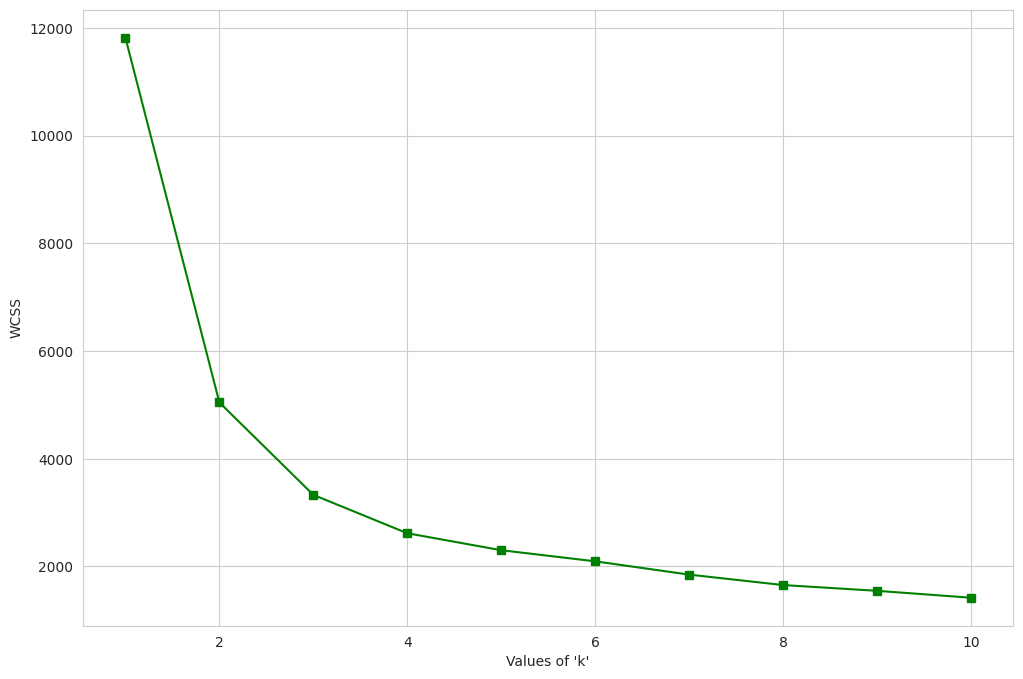

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300,
                  n_init = 10, random_state = 0)
kmeans.fit(X_reduced)

labels = kmeans.labels_  # Cluster labels for each point
centroids = kmeans.cluster_centers_  # Cluster centroids

wcss = {}
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_reduced)
    wcss[i] = kmeans.inertia_

plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

### Silhouette Score Analysis

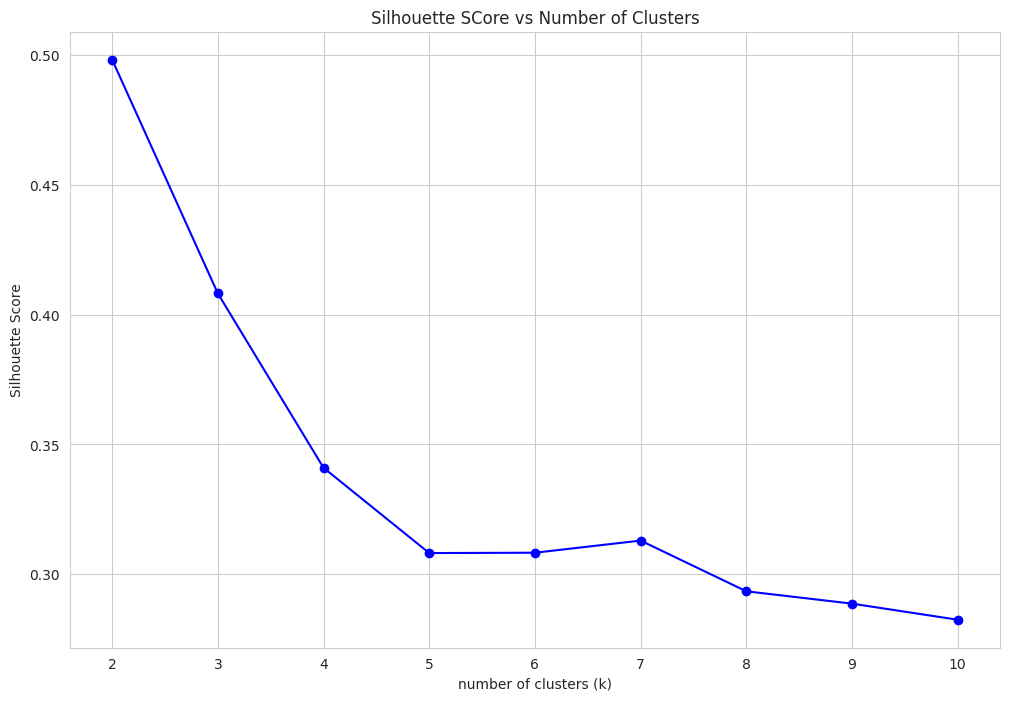

In [13]:
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    silhouette_scores[k] = silhouette_score(X_reduced, labels)

plt.plot(silhouette_scores.keys(), silhouette_scores.values(), 'bo-')
plt.xlabel('number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette SCore vs Number of Clusters')
plt.grid(True)
plt.show()

# print("Silhouette scores:")
# print(silhouette_scores)

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_reduced)
y_kmeans = kmeans.predict(X_reduced)

fig = px.scatter_3d(x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2], color=y_kmeans)
fig.show()

### DBSCAN


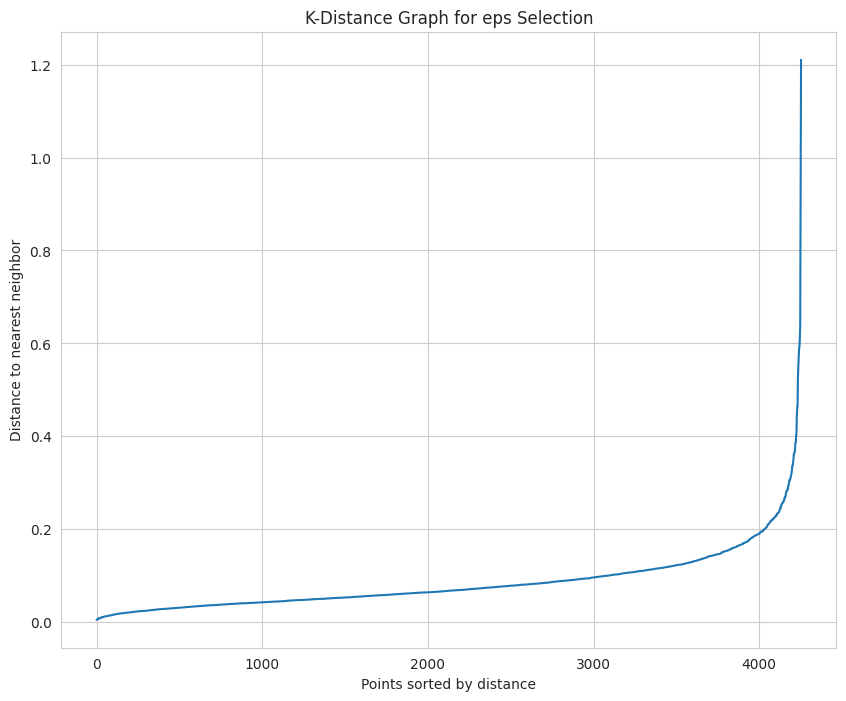

In [15]:
# Determine optimal eps using k-distance graph
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=20).fit(X_reduced)
distances, indices = nn.kneighbors(X_reduced)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10, 8))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to nearest neighbor')
plt.title('K-Distance Graph for eps Selection')
plt.show()

In [16]:

# Find best min_samples and eps using grid search with silhouette score
min_samples_range = range(3, 5)
epsilon_range = np.arange(0.1, 0.3, 0.01) # change both to 0.3, 2 later
results = []

for ms in min_samples_range:
    for ep in epsilon_range:
        labels = DBSCAN(min_samples=ms, eps=ep).fit(X_reduced).labels_
        
        # only compute silhouette if we have actual clusters (not just noise)
        if len(set(labels)) > 1 and -1 not in labels or (len(set(labels)) > 2 and -1 in labels):
            score = silhouette_score(X_reduced, labels)
            results.append((ms, ep, score))

if results:
    best_min_samples, best_eps, best_score = sorted(results, key=lambda x: x[-1])[-1]
    print(f"Best silhouette score: {best_score:.4f}")
    print(f"Best min_samples: {best_min_samples}")
    print(f"Best eps: {best_eps:.4f}")
else:
    print("No valid clusters found in search range")

Best silhouette score: 0.1964
Best min_samples: 4
Best eps: 0.2900


In [17]:
# DBSCAN clustering using best parameters from grid search above
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
y_dbscan = dbscan.fit_predict(X_reduced)

print("DBSCAN cluster counts:")
print(pd.Series(y_dbscan).value_counts().sort_index())

# 3D plot
fig = px.scatter_3d(x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2], color=y_dbscan)
fig.show()

DBSCAN cluster counts:
-1     139
 0       5
 1    4092
 2       4
 3       6
 4       4
 5       3
Name: count, dtype: int64


### hierarchical clustering | agglomerative


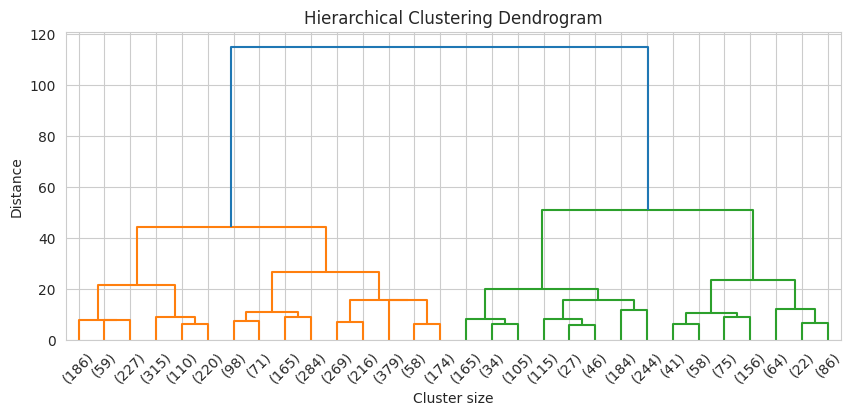

In [18]:
# Dendrogram to visualize hierarchy
Z = linkage(X_reduced, method='ward')
plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode='lastp', p=30)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

# Agglomerative clustering with n=3 clusters
hierarchical = AgglomerativeClustering(n_clusters=3)
y_hierarchical = hierarchical.fit_predict(X_reduced)

# print("Hierarchical cluster counts:")
# print(pd.Series(y_hierarchical).value_counts().sort_index())

# 3D plot
# fig = px.scatter_3d(x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2], color=y_hierarchical)
# fig.show()

## model comparison through metrics

In [19]:
# Compute metrics for KMeans
sil_kmeans = silhouette_score(X_reduced, y_kmeans)
db_kmeans = davies_bouldin_score(X_reduced, y_kmeans)
ch_kmeans = calinski_harabasz_score(X_reduced, y_kmeans)

# Compute metrics for Hierarchical
sil_hierarchical = silhouette_score(X_reduced, y_hierarchical)
db_hierarchical = davies_bouldin_score(X_reduced, y_hierarchical)
ch_hierarchical = calinski_harabasz_score(X_reduced, y_hierarchical)

# Compute metrics for DBSCAN (exclude noise labeled as -1)
mask_dbscan = y_dbscan != -1
sil_dbscan = silhouette_score(X_reduced[mask_dbscan], y_dbscan[mask_dbscan])
db_dbscan = davies_bouldin_score(X_reduced[mask_dbscan], y_dbscan[mask_dbscan])
ch_dbscan = calinski_harabasz_score(X_reduced[mask_dbscan], y_dbscan[mask_dbscan])

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['KMeans', 'DBSCAN', 'Hierarchical'],
    'Silhouette': [sil_kmeans, sil_dbscan, sil_hierarchical],
    'Davies-Bouldin': [db_kmeans, db_dbscan, db_hierarchical],
    'Calinski-Harabasz': [ch_kmeans, ch_dbscan, ch_hierarchical]
})

print("Model Comparison:")
print("Higher Silhouette & Calinski-Harabasz = better")
print("Lower Davies-Bouldin = better")
display(comparison_df)

Model Comparison:
Higher Silhouette & Calinski-Harabasz = better
Lower Davies-Bouldin = better


,Model,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.342414,0.957456,4977.880866
1,DBSCAN,0.222004,0.563679,27.678317
2,Hierarchical,0.382224,0.906255,4278.103574


#### based on metrics, KMeans scored the highest, most consistent balance of high separation and high density across the majority of metrics.

## cLuster interpretation and archetype naming

In [20]:
df_relevant['Cluster'] = y_kmeans

print("=== Cluster 0 ===")
display(df_relevant[df_relevant['Cluster'] == 0].head(5))

print("\n=== Cluster 1 ===")
display(df_relevant[df_relevant['Cluster'] == 1].head(5))

print("\n=== Cluster 2 ===")
display(df_relevant[df_relevant['Cluster'] == 2].head(5))

# print("\n=== Cluster 3 ===")
# display(df_relevant[df_relevant['Cluster'] == 3].head(5))

# print("\n=== Cluster 4 ===")
# display(df_relevant[df_relevant['Cluster'] == 4].head(5))


=== Cluster 0 ===


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,User_Score_Scaled,User_Critic_Discrepancy,Cluster
26,Brain Age 2: More Training in Minutes a Day,3.43,5.35,5.32,1.18,15.29,77.0,37.0,7.1,19.0,71.0,-6.0,0
61,Just Dance 3,5.95,3.11,0.00,1.06,10.12,74.0,15.0,7.8,16.0,78.0,4.0,0
68,Just Dance 2,5.80,2.85,0.01,0.78,9.44,74.0,24.0,7.3,24.0,73.0,-1.0,0
116,Just Dance 4,4.05,2.16,0.00,0.55,6.76,74.0,10.0,7.3,28.0,73.0,-1.0,0
123,Big Brain Academy,1.66,2.75,1.60,0.62,6.62,74.0,45.0,7.4,27.0,74.0,0.0,0



=== Cluster 1 ===


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,User_Score_Scaled,User_Critic_Discrepancy,Cluster
266,Namco Museum,3.00,1.11,0.05,0.07,4.24,79.0,10.0,7.3,6.0,73.0,-6.0,1
343,MySims,1.58,1.59,0.08,0.41,3.66,67.0,15.0,7.3,13.0,73.0,6.0,1
446,Personal Trainer: Cooking,0.90,1.00,1.03,0.17,3.11,81.0,12.0,7.8,10.0,78.0,-3.0,1
597,Madden NFL 08,2.14,0.08,0.00,0.35,2.57,78.0,11.0,7.8,17.0,78.0,0.0,1
611,Art Academy,0.26,1.65,0.33,0.28,2.52,75.0,15.0,8.0,5.0,80.0,5.0,1



=== Cluster 2 ===


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,User_Score_Scaled,User_Critic_Discrepancy,Cluster
0,Wii Sports,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,80.0,4.0,2
2,Mario Kart Wii,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,83.0,1.0,2
3,Wii Sports Resort,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,80.0,0.0,2
6,New Super Mario Bros.,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,85.0,-4.0,2
8,New Super Mario Bros. Wii,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,594.0,84.0,-3.0,2


# Final Analysis & Conclusion

### Cluster 0 - Mass-Market Blockbusters (Worthwhile) (Rank 2)
High global sales but mixed critic and user scores; appeal to casual audiences and achieve strong commercial success, making them worthwhile.

### Cluster 1 - Underrated Gems (Worthwhile)  (Rank 3)
Moderate sales with user scores often exceeding critic scores; better received by players than reviewers, with decent sales and positive player reception.

### Cluster 2 - Commercial Titans (Worthwhile)  (Rank 1)
Extremely high sales, strong user scores, and generally favorable critic reviews; immense commercial success and high player approval define this cluster.

---

**Conclusion:**

Put conclusion after finalizing paper


# Export the clustered data that the model made.

In [21]:
# Export the clustered data to CSV file
output_filename = 'clustered_video_games.csv'

# Save the dataframe with cluster assignments
df_relevant.to_csv(output_filename, index=False)

print(f"Clustered data exported successfully!")
print(f"File saved as: {output_filename}")
print(f"\nTotal games exported: {len(df_relevant)}")
print(f"\nCluster distribution:")
print(df_relevant['Cluster'].value_counts().sort_index())

# Show preview of exported data
print(f"\nPreview of exported data:")
display(df_relevant.head(10))


Clustered data exported successfully!
File saved as: clustered_video_games.csv

Total games exported: 4253

Cluster distribution:
Cluster
0    1497
1    1332
2     417
3    1007
Name: count, dtype: int64

Preview of exported data:


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,User_Score_Scaled,User_Critic_Discrepancy,Cluster
0,Wii Sports,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,80.0,4.0,2
2,Mario Kart Wii,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,83.0,1.0,2
3,Wii Sports Resort,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,80.0,0.0,2
6,New Super Mario Bros.,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,85.0,-4.0,2
7,Wii Play,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,66.0,8.0,3
8,New Super Mario Bros. Wii,14.44,6.94,4.70,2.24,28.32,87.0,80.0,8.4,594.0,84.0,-3.0,2
11,Mario Kart DS,9.71,7.47,4.13,1.90,23.21,91.0,64.0,8.6,464.0,86.0,-5.0,2
13,Wii Fit,8.92,8.03,3.60,2.15,22.70,80.0,63.0,7.7,146.0,77.0,-3.0,3
14,Kinect Adventures!,15.00,4.89,0.24,1.69,21.81,61.0,45.0,6.3,106.0,63.0,2.0,3
15,Wii Fit Plus,9.01,8.49,2.53,1.77,21.79,80.0,33.0,7.4,52.0,74.0,-6.0,3
